# Projeto de BI em PySpark

# Diagrama 

Conforme o diagrama proposto, este projeto utilizará 3 tabelas
*   1 tabela fato - Todos os registros de músicas escutadas por usuário
*   1 tabela dimensão - Todos os usuários
*   1 tabela dimensão - Todas as musicas/artista


Diagrama feito no Draw.io

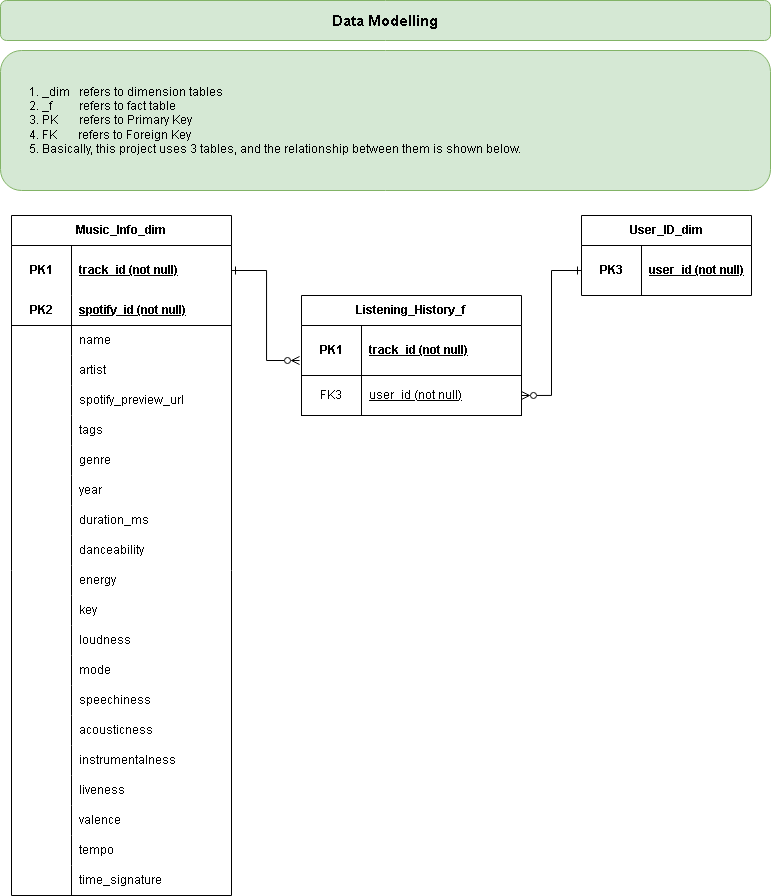

# Dashboard desenvolvido para a área de BI

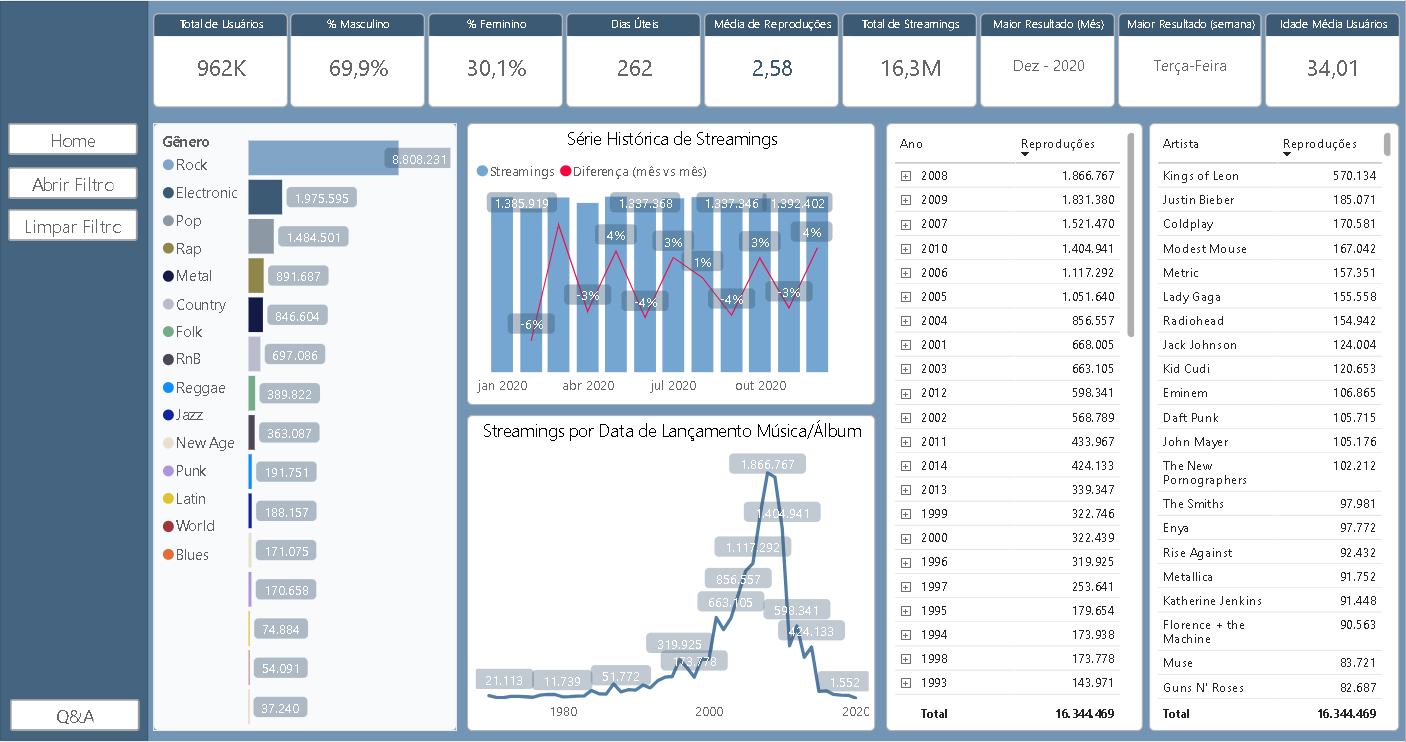

### Principais Pontos do Dashboard:

- Conexão realizada via Athena
- Dados históricos de streaming para o ano de 2020
- Ideia principal:
    - Apresentar o comportamento de streamings ao longo do ano de 2020, mapeando o principal gênero dos usuários.
    - Quais artistas, álbuns e data de lançamento de discos e singles apresentaram maiores resultados.
    - Fornecer um dashboard para entendimento macro das informações históricas, e futuramente desenvolver estudos específicos, de acordo com a necessidade da empresa.
    
O arquivo PBIX para edição do dashboard está diponível no GitHub.

### Principais Pontos do Notebook

### Arquivos criados e salvos em um bucket (S3) no formato Parquet 

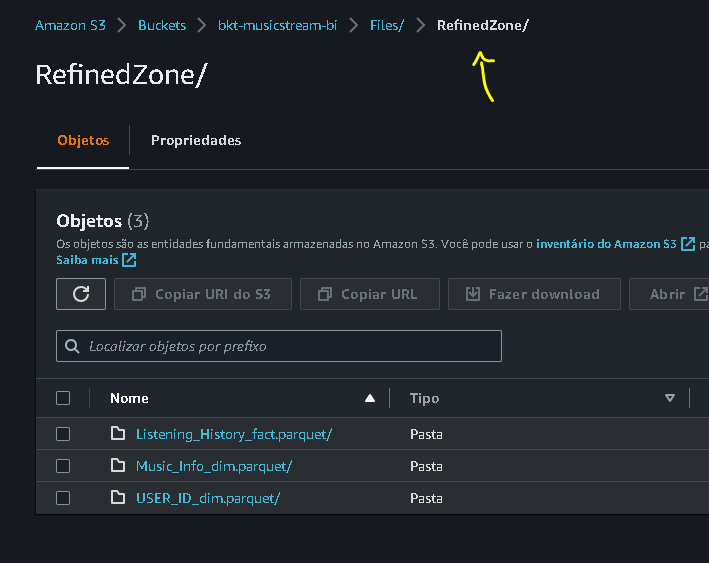

### Tabelas Criadas

# Processos do Notebook

## Iniciar sessão Spark

In [4]:
#!/usr/bin/env python
# coding: utf-8

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
import os
import sys
import pytz
import numpy as np
import datetime
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, udf, lpad, translate
from datetime import datetime 
from datetime import timedelta
from datetime import date
from dateutil.relativedelta import relativedelta
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#udf para tratamento de coluna tipo data
func = udf(lambda x: datetime.strptime(x, '%d-%m-%Y'), DateType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Pacotes Ativos no Cluster
#sc.list_packages()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
#!pip install Kaggle

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
music_info_raw = spark.read.csv("s3://bkt-musicstream-bi/Files/RawZone/Music_Info.csv", sep=",", header=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
user_listening_history_raw = spark.read.csv("s3://bkt-musicstream-bi/Files/RawZone/User_Listening_History.csv", sep=",", header=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
music_info_raw.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+----------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|          track_id|            name|         artist| spotify_preview_url|          spotify_id|                tags|genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+------------------+----------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|TRIOREW128F424EAF0|  Mr. Brightside|    The Killers|https://p.scdn.co...|09ZQ5TmUG8TSL56n0...|rock, alternative...| null|2004|     222200|       0.355| 0.918|  1|   -4.36|   1|     0.0746|     0.00119|             0.0| 

In [12]:
"""
# +------------------+----------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|               _c0|             _c1|            _c2|                 _c3|                 _c4|                 _c5|  _c6| _c7|        _c8|         _c9|  _c10|_c11|    _c12|_c13|       _c14|        _c15|            _c16|    _c17|   _c18|   _c19|          _c20|
+------------------+----------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|          track_id|            name|         artist| spotify_preview_url|          spotify_id|                tags|genre|year|duration_ms|danceability|energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
|TRIOREW128F424EAF0|  Mr. Brightside|    The Killers|https://p.scdn.co...|09ZQ5TmUG8TSL56n0...|rock, alternative...| null|2004|     222200|       0.355| 0.918|   1|   -4.36|   1|     0.0746|     0.00119|             0.0|  0.0971|   0.24|148.114|             4|
|TRRIVDJ128F429B0E8|      Wonderwall|          Oasis|https://p.scdn.co...|06UfBBDISthj1ZJAt...|rock, alternative...| null|2006|     258613|       0.409| 0.892|   2|  -4.373|   1|     0.0336|    0.000807|             0.0|   0.207|  0.651|174.426|             4|
|TROUVHL128F426C441| Come as You Are|        Nirvana|https://p.scdn.co...|0keNu0t0tqsWtExGM...|rock, alternative...|  RnB|1991|     218920|       0.508| 0.826|   4|  -5.783|   0|       0.04|    0.000175|        0.000459|  0.0878|  0.543|120.012|             4|
|TRUEIND128F93038C4|     Take Me Out|Franz Ferdinand|https://p.scdn.co...|0ancVQ9wEcHVd0RrG...|rock, alternative...| null|2004|     237026|       0.279| 0.664|   9|  -8.851|   1|     0.0371|    0.000389|        0.000655|   0.133|   0.49| 104.56|             4|
|TRLNZBD128F935E4D8|           Creep|      Radiohead|https://p.scdn.co...|01QoK9DA7VTeTSE3M...|rock, alternative...|  RnB|2008|     238640|       0.515|  0.43|   7|  -9.935|   1|     0.0369|      0.0102|        0.000141|   0.129|  0.104| 91.841|             4|
|TRUMISQ128F9340BEE|Somebody Told Me|    The Killers|https://p.scdn.co...|0FNmIQ7u45Lhdn6RH...|rock, alternative...| null|2005|     198480|       0.508| 0.979|  10|  -4.289|   0|     0.0847|    8.71e-05|        0.000643|  0.0641|  0.704| 138.03|             4|
|TRVCCWR128F9304A30|    Viva la Vida|       Coldplay|https://p.scdn.co...|08A1lZeyLMWH58DT6...|rock, alternative...| null|2013|     235384|       0.588| 0.806|   8|  -7.903|   1|      0.105|       0.153|             0.0|  0.0634|   0.52|137.973|             4|
|TRXOGZT128F424AD74|    Karma Police|      Radiohead|https://p.scdn.co...|01puceOqImrzSfKDA...|rock, alternative...| null|1996|     264066|        0.36| 0.505|   7|  -9.129|   1|      0.026|      0.0626|        9.22e-05|   0.172|  0.317| 74.807|             4|
|TRMZXEW128F9341FD5|   The Scientist|       Coldplay|https://p.scdn.co...|0GSSsT9szp0rJkBrY...|rock, alternative...| Rock|2007|     311014|       0.566| 0.429|   5|  -7.826|   1|     0.0242|       0.715|        1.44e-05|    0.12|  0.173|146.365|             4|
+------------------+----------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
only showing top 10 rows

"""

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'\n# +------------------+----------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+\n|               _c0|             _c1|            _c2|                 _c3|                 _c4|                 _c5|  _c6| _c7|        _c8|         _c9|  _c10|_c11|    _c12|_c13|       _c14|        _c15|            _c16|    _c17|   _c18|   _c19|          _c20|\n+------------------+----------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+\n|          track_id|            name|         artist| spotify_preview_url|          spotify_id|                tags|genre|year|duration_ms|danceability|energy| key|loudness|mode|speechiness|acousticness|instru

In [13]:
user_listening_history_raw.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+--------------------+---------+
|          track_id|             user_id|playcount|
+------------------+--------------------+---------+
|TRIRLYL128F42539D1|b80344d063b5ccb32...|        1|
|TRFUPBA128F934F7E1|b80344d063b5ccb32...|        1|
|TRLQPQJ128F42AA94F|b80344d063b5ccb32...|        1|
|TRTUCUY128F92E1D24|b80344d063b5ccb32...|        1|
|TRHDDQG12903CB53EE|b80344d063b5ccb32...|        1|
|TRGRDEC128F423C07D|b80344d063b5ccb32...|        1|
|TRRYCBO128F932A2C7|b80344d063b5ccb32...|        1|
|TRUTULC128F4293712|b80344d063b5ccb32...|        1|
|TRAAHSY128F147BB5C|b80344d063b5ccb32...|        2|
|TRDLMWP128F426BF6C|b80344d063b5ccb32...|        1|
+------------------+--------------------+---------+
only showing top 10 rows

In [14]:
"""

+------------------+--------------------+---------+
|               _c0|                 _c1|      _c2|
+------------------+--------------------+---------+
|          track_id|             user_id|playcount|
|TRIRLYL128F42539D1|b80344d063b5ccb32...|        1|
|TRFUPBA128F934F7E1|b80344d063b5ccb32...|        1|
|TRLQPQJ128F42AA94F|b80344d063b5ccb32...|        1|
|TRTUCUY128F92E1D24|b80344d063b5ccb32...|        1|
|TRHDDQG12903CB53EE|b80344d063b5ccb32...|        1|
|TRGRDEC128F423C07D|b80344d063b5ccb32...|        1|
|TRRYCBO128F932A2C7|b80344d063b5ccb32...|        1|
|TRUTULC128F4293712|b80344d063b5ccb32...|        1|
|TRAAHSY128F147BB5C|b80344d063b5ccb32...|        2|
+------------------+--------------------+---------+
only showing top 10 rows

"""

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'\n\n+------------------+--------------------+---------+\n|               _c0|                 _c1|      _c2|\n+------------------+--------------------+---------+\n|          track_id|             user_id|playcount|\n|TRIRLYL128F42539D1|b80344d063b5ccb32...|        1|\n|TRFUPBA128F934F7E1|b80344d063b5ccb32...|        1|\n|TRLQPQJ128F42AA94F|b80344d063b5ccb32...|        1|\n|TRTUCUY128F92E1D24|b80344d063b5ccb32...|        1|\n|TRHDDQG12903CB53EE|b80344d063b5ccb32...|        1|\n|TRGRDEC128F423C07D|b80344d063b5ccb32...|        1|\n|TRRYCBO128F932A2C7|b80344d063b5ccb32...|        1|\n|TRUTULC128F4293712|b80344d063b5ccb32...|        1|\n|TRAAHSY128F147BB5C|b80344d063b5ccb32...|        2|\n+------------------+--------------------+---------+\nonly showing top 10 rows\n\n'

# Num Linhas/Colunas (Shape)

In [15]:
#numero colunas e linhas
num_rows = music_info_raw.count()
num_cols = len(music_info_raw.columns)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print('Shape: ({}, {})'.format(num_rows, num_cols))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Shape: (50683, 21)

In [17]:
#numero colunas e linhas
num_rows1 = user_listening_history_raw.count()
num_cols1 = len(user_listening_history_raw.columns)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
print('Shape: ({}, {})'.format(num_rows1, num_cols1))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Shape: (9711301, 3)

# Desc Colunas (Columns description)

In [19]:
#colunas
music_info_raw.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id', 'tags', 'genre', 'year', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

In [20]:
#colunas
user_listening_history_raw.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['track_id', 'user_id', 'playcount']

# Schema

In [21]:
#Schema Tabela
#Podemos notar que todos os dados foram armazenados como string, faremos alteracoes futuramente para melhor performance
user_listening_history_raw.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- track_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- playcount: string (nullable = true)

In [22]:
#Schema Tabela
#Podemos notar que todos os dados foram armazenados como string, faremos alteracoes futuramente para melhor performance
music_info_raw.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- track_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- spotify_preview_url: string (nullable = true)
 |-- spotify_id: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- year: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- time_signature: string (nullable = true)

# Carregue o arquivo com inferência automática de tipos e cabeçalho
xd = spark.read.options(inferSchema="true", header="true").csv("s3://bkt-musicstream-bi/Files/RawZone/Music_Info.csv", sep=",")

# Exiba o esquema inferido
xd.printSchema()

# Verificando a existência de registros nulos

### Criando uma funcao (creating a function)

In [23]:
def check_nulls(dataframe, name) -> None:
    '''
    Verifica e exibe a quantidade de valores nulos em cada coluna do dataframe.

    :param dataframe: DataFrame
        Dataframe a ser analisado.
    :param name: str
        Nome identificando o dataframe para exibição na saída.
    '''
    print(f'\n{name.upper()} { "-" * (100 - len(name))}')
    for coluna in dataframe.columns:
        qty = dataframe.filter(dataframe[coluna].isNull()).count()
        if qty >= 1:
            print(f'{coluna}: {qty}')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Aplicando a funcao

In [24]:
#Utilizando a def
check_nulls(user_listening_history_raw, "listening_history")
check_nulls(music_info_raw,"music_info")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


LISTENING_HISTORY -----------------------------------------------------------------------------------

MUSIC_INFO ------------------------------------------------------------------------------------------
tags: 1127
genre: 28335

In [25]:
#Podemos verificar que o historico de musicas nao apresenta nenhum valor nulo, por se tratar de uma tabela fato
#Verificaremos posteriormente se todos os itens da Fato estao presentes nas tabelas dimensao
#Por questao de boas praticas em modelagem de dados

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Verificando a existência de linhas duplicadas

In [26]:
def check_duplicates(dataframe, fields) -> None:
    '''
    Verifica e exibe uma amostra de 5 registros duplicados com base em um ou mais campos especificados.

    :param dataframe: DataFrame
        Dataframe a ser analisado.
    :param fields: str ou list de str
        Nome do campo ou lista de campos a serem usados como referência para identificar duplicatas.
    '''
    duplicate = dataframe.groupBy(fields) \
        .agg(count('*').alias('qty')) \
        .where(col('qty') > 1) \
        .orderBy(desc('qty'))
    duplicate.show(5, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
from pyspark.sql.functions import col, count, desc

def check_duplicates(dataframe, fields) -> None:
    '''
    Verifica e exibe uma amostra de 5 registros duplicados com base em um ou mais campos especificados.

    :param dataframe: DataFrame
        Dataframe a ser analisado.
    :param fields: str ou list de str
        Nome do campo ou lista de campos a serem usados como referência para identificar duplicatas.
    '''
    duplicates = dataframe.groupBy(fields) \
        .agg(count('*').alias('qty')) \
        .where(col('qty') > 1) \
        .orderBy(desc('qty'))
    return duplicates
    #duplicates.show(5, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Aplicando a funcao

In [28]:
for column in music_info_raw.columns:
    duplicates = check_duplicates(music_info_raw, column)
    duplicates.show(20, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---+
|track_id|qty|
+--------+---+
+--------+---+

+----+---+
|name|qty|
+----+---+
+----+---+

+------------------+---+
|artist            |qty|
+------------------+---+
|The Rolling Stones|132|
|Radiohead         |111|
|Autechre          |105|
|Tom Waits         |100|
|Bob Dylan         |98 |
|The Cure          |94 |
|Metallica         |85 |
|Johnny Cash       |84 |
|Nine Inch Nails   |83 |
|Sonic Youth       |81 |
|In Flames         |76 |
|Elliott Smith     |76 |
|Iron Maiden       |76 |
|Boards of Canada  |75 |
|Mogwai            |75 |
|Amorphis          |74 |
|Korn              |72 |
|Beastie Boys      |70 |
|Animal Collective |70 |
|Foo Fighters      |70 |
+------------------+---+
only showing top 20 rows

+-----------------------------------------------------------------------------------------------------------+---+
|spotify_preview_url                                                                                        |qty|
+---------------------------------------

### Vamos verificar o motivo de algumas linhas estarem duplicadas na coluna 'spotify_id'


In [29]:
# Exemplo
music_info_filtro = music_info_raw.filter("spotify_id = '1Ntzk4JoxcAsrWi73MoBjr'")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
# Note: O nome da musica na coluna 'name' apresenta erro de digitacao
music_info_filtro.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+---------+-------------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+
|          track_id|     name|             artist| spotify_preview_url|          spotify_id|                tags|genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence| tempo|time_signature|
+------------------+---------+-------------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+
|TRXUYQW128F42370DB|hHallmark|Broken Social Scene|https://p.scdn.co...|1Ntzk4JoxcAsrWi73...|alternative, indi...| Rock|2004|     233706|       0.523| 0.583|  0| -10.694|   1|     0.0434|      0.0879|           0.109|   0.144|  0.172

In [31]:
"""

+------------------+---------+-------------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+
|          track_id|     name|             artist| spotify_preview_url|          spotify_id|                tags|genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence| tempo|time_signature|
+------------------+---------+-------------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+
|TRXUYQW128F42370DB|hHallmark|Broken Social Scene|https://p.scdn.co...|1Ntzk4JoxcAsrWi73...|alternative, indi...| Rock|2004|     233706|       0.523| 0.583|  0| -10.694|   1|     0.0434|      0.0879|           0.109|   0.144|  0.172|119.98|             3|
|TRCUHWL128F4249F1A| Hallmark|Broken Social Scene|https://p.scdn.co...|1Ntzk4JoxcAsrWi73...|indie, alternativ...| null|2004|     233706|       0.523| 0.583|  0| -10.694|   1|     0.0434|      0.0879|           0.109|   0.144|  0.172|119.98|             3|
+------------------+---------+-------------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+


"""

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'\n\n+------------------+---------+-------------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+\n|          track_id|     name|             artist| spotify_preview_url|          spotify_id|                tags|genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence| tempo|time_signature|\n+------------------+---------+-------------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+\n|TRXUYQW128F42370DB|hHallmark|Broken Social Scene|https://p.scdn.co...|1Ntzk4JoxcAsrWi73...|alternative, indi...| Rock|2004|     233706|       0.523| 0.583|  0| -10.694|   1|     0.0434|      0.0879|           0.109|   0.144

# Verificar o total de linhas com duplicacao da coluna 'spotify_id'

In [32]:
from pyspark.sql.functions import count

# Group the DataFrame by 'spotify_id' and count the occurrences
duplicate_counts = music_info_raw.groupBy('spotify_id').agg(count('*').alias('count'))

# Filter the DataFrame to keep only rows where count > 1
duplicate_rows = music_info_raw.join(duplicate_counts, on='spotify_id').filter('count > 1')

# Show the duplicate rows DataFrame
# duplicate_rows.sort('name').show(20, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
"""

+----------------------+------------------+--------------------------+-------------------+-----------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----+
|spotify_id            |track_id          |name                      |artist             |spotify_preview_url                                                                                        |tags                                                                                                                                                         |genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |time_signature|count|
+----------------------+------------------+--------------------------+-------------------+-----------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----+
|5vYA1mW9g2Coh1HUFUSmlb|TRGGALK12903CB68E5|3 AM                      |Matchbox Twenty    |https://p.scdn.co/mp3-preview/cb68c9ae8925bb3fc45544e5f21de17df18b957d?cid=774b29d4f13844c495f206cafdad9c86|rock, alternative, pop, alternative_rock, 90s, male_vocalists                                                                                                |null |1996|225946     |0.521       |0.673 |8  |-8.685  |1   |0.0284     |0.00573     |0.0             |0.12    |0.543  |108.031|4             |2    |
|5vYA1mW9g2Coh1HUFUSmlb|TRLOXMF128F934BF04|3AM                       |Matchbox Twenty    |https://p.scdn.co/mp3-preview/cb68c9ae8925bb3fc45544e5f21de17df18b957d?cid=774b29d4f13844c495f206cafdad9c86|rock, alternative, 90s, piano, american, pop_rock                                                                                                            |null |1996|225946     |0.521       |0.673 |8  |-8.685  |1   |0.0284     |0.00573     |0.0             |0.12    |0.543  |108.031|4             |2    |
|00otCiz9kUb3Vg7LPKNCZG|TRJNHPN128F92EF139|Adagio For Strings        |Samuel Barber      |https://p.scdn.co/mp3-preview/fd1b6adbed0cbdd3dce0eb4e39146a0857afec53?cid=774b29d4f13844c495f206cafdad9c86|instrumental, classical, soundtrack, beautiful                                                                                                               |null |2014|431412     |0.14        |0.0947|10 |-18.599 |0   |0.0458     |0.978       |0.478           |0.0735  |0.0365 |84.56  |4             |2    |
|00otCiz9kUb3Vg7LPKNCZG|TRLSRQD128F426CFF8|Adagio for Strings, Op. 11|Samuel Barber      |https://p.scdn.co/mp3-preview/fd1b6adbed0cbdd3dce0eb4e39146a0857afec53?cid=774b29d4f13844c495f206cafdad9c86|classical                                                                                                                                                    |null |2014|431412     |0.14        |0.0947|10 |-18.599 |0   |0.0458     |0.978       |0.478           |0.0735  |0.0365 |84.56  |4             |2    |
|22Ty5gK6zbw0hRtGypTuX5|TRVENST12903D13BBB|Do You Love Me Now        |The Breeders       |https://p.scdn.co/mp3-preview/6a6a7db7aca75f89d1676a80b9a8d26f174749e3?cid=774b29d4f13844c495f206cafdad9c86|rock, alternative, indie, female_vocalists, alternative_rock, 90s                                                                                            |null |1993|181800     |0.486       |0.233 |2  |-11.535 |1   |0.0365     |0.0319      |0.107           |0.102   |0.32   |134.187|4             |2    |
|22Ty5gK6zbw0hRtGypTuX5|TRHNAWF128F423EAE4|Do You Love Me Now?       |The Breeders       |https://p.scdn.co/mp3-preview/6a6a7db7aca75f89d1676a80b9a8d26f174749e3?cid=774b29d4f13844c495f206cafdad9c86|rock, alternative, indie, female_vocalists, alternative_rock, 90s, new_wave, love, grunge                                                                    |Rock |1993|181800     |0.486       |0.233 |2  |-11.535 |1   |0.0365     |0.0319      |0.107           |0.102   |0.32   |134.187|4             |2    |
|3MUviQJP5DSYI3Li4EbYTQ|TRRLAHF12903CAFEA1|Greatest Hit              |Annie              |https://p.scdn.co/mp3-preview/82e186b1ddf2b2a51c244effb7691e00bef9c1f2?cid=774b29d4f13844c495f206cafdad9c86|electronic, pop, dance, house                                                                                                                                |null |2004|220293     |0.786       |0.854 |10 |-3.249  |0   |0.138      |0.00261     |0.000171        |0.155   |0.547  |127.128|4             |2    |
|1Ntzk4JoxcAsrWi73MoBjr|TRCUHWL128F4249F1A|Hallmark                  |Broken Social Scene|https://p.scdn.co/mp3-preview/68604cdb33249a23ac2e8a5d82cda296e7524ccb?cid=774b29d4f13844c495f206cafdad9c86|indie, alternative_rock, instrumental, post_rock                                                                                                             |null |2004|233706     |0.523       |0.583 |0  |-10.694 |1   |0.0434     |0.0879      |0.109           |0.144   |0.172  |119.98 |3             |2    |
|02VsIBmSkhc7uHNyPViZR3|TRXHJQY128F42B5094|How Do U Want It          |2Pac               |https://p.scdn.co/mp3-preview/59f243514e63d634d0513e28f159f201ff3f0984?cid=774b29d4f13844c495f206cafdad9c86|rap, hip_hop, american                                                                                                                                       |Rap  |2011|289000     |0.832       |0.785 |8  |-2.859  |1   |0.093      |0.111       |6.86e-06        |0.0623  |0.812  |92.468 |4             |2    |
|02VsIBmSkhc7uHNyPViZR3|TRLOZQZ128F92E8A3F|How Do You Want It        |2Pac               |https://p.scdn.co/mp3-preview/59f243514e63d634d0513e28f159f201ff3f0984?cid=774b29d4f13844c495f206cafdad9c86|rap, hip_hop                                                                                                                                                 |null |2011|289000     |0.832       |0.785 |8  |-2.859  |1   |0.093      |0.111       |6.86e-06        |0.0623  |0.812  |92.468 |4             |2    |
|09jsAIZF9ThihIzdrw4KAS|TRZBNQU128F148C04F|Je Pense A Toi            |Amadou & Mariam    |https://p.scdn.co/mp3-preview/adcdf1077f16f2c71c5c7a73ee4c99db207f8602?cid=774b29d4f13844c495f206cafdad9c86|null                                                                                                                                                         |null |2005|316880     |0.68        |0.399 |11 |-11.585 |0   |0.0279     |0.749       |0.00161         |0.158   |0.828  |106.349|4             |2    |
|09jsAIZF9ThihIzdrw4KAS|TRGCZFO128F92EE221|Je pense à toi            |Amadou & Mariam    |https://p.scdn.co/mp3-preview/adcdf1077f16f2c71c5c7a73ee4c99db207f8602?cid=774b29d4f13844c495f206cafdad9c86|alternative, beautiful, french                                                                                                                               |null |2005|316880     |0.68        |0.399 |11 |-11.585 |0   |0.0279     |0.749       |0.00161         |0.158   |0.828  |106.349|4             |2    |
|3MUviQJP5DSYI3Li4EbYTQ|TRCEFVZ128F4283203|The Greatest Hit          |Annie              |https://p.scdn.co/mp3-preview/82e186b1ddf2b2a51c244effb7691e00bef9c1f2?cid=774b29d4f13844c495f206cafdad9c86|electronic, pop, female_vocalists, dance, electro                                                                                                            |null |2004|220293     |0.786       |0.854 |10 |-3.249  |0   |0.138      |0.00261     |0.000171        |0.155   |0.547  |127.128|4             |2    |
|0thdzbW0cRKCx12VbBRB6T|TRRZUGN128F42A1EEE|There There               |Radiohead          |https://p.scdn.co/mp3-preview/9e96ffdf29fceec324b97d331915f2390536ad7a?cid=774b29d4f13844c495f206cafdad9c86|rock, electronic, alternative, indie, alternative_rock, experimental, indie_rock, british, 00s, britpop                                                      |Rock |2008|323600     |0.614       |0.677 |9  |-8.317  |0   |0.0323     |0.0193      |0.518           |0.108   |0.717  |126.477|4             |2    |
|0thdzbW0cRKCx12VbBRB6T|TRXFHCL128F92E0989|There, There              |Radiohead          |https://p.scdn.co/mp3-preview/9e96ffdf29fceec324b97d331915f2390536ad7a?cid=774b29d4f13844c495f206cafdad9c86|rock, electronic, alternative, indie, alternative_rock, classic_rock, experimental, indie_rock, progressive_rock, british, downtempo, male_vocalists, britpop|null |2008|323600     |0.614       |0.677 |9  |-8.317  |0   |0.0323     |0.0193      |0.518           |0.108   |0.717  |126.477|4             |2    |
|0ndKJL8gA4zLl317M7vndn|TRJQFIT128E0781CED|Too Much Too Young        |The Specials       |https://p.scdn.co/mp3-preview/fc256eb2d041b8454f2d63346a3ca23e314c599a?cid=774b29d4f13844c495f206cafdad9c86|punk, 80s, new_wave, reggae, ska                                                                                                                             |null |2012|116160     |0.597       |0.839 |2  |-9.052  |1   |0.0471     |0.447       |0.000134        |0.31    |0.965  |156.058|4             |2    |
|0ndKJL8gA4zLl317M7vndn|TRDTUTO128F422F138|Too Much Too Young (Live) |The Specials       |https://p.scdn.co/mp3-preview/fc256eb2d041b8454f2d63346a3ca23e314c599a?cid=774b29d4f13844c495f206cafdad9c86|ska                                                                                                                                                          |null |2012|116160     |0.597       |0.839 |2  |-9.052  |1   |0.0471     |0.447       |0.000134        |0.31    |0.965  |156.058|4             |2    |
|1Ntzk4JoxcAsrWi73MoBjr|TRXUYQW128F42370DB|hHallmark                 |Broken Social Scene|https://p.scdn.co/mp3-preview/68604cdb33249a23ac2e8a5d82cda296e7524ccb?cid=774b29d4f13844c495f206cafdad9c86|alternative, indie, ambient, soundtrack, psychedelic, post_rock                                                                                              |Rock |2004|233706     |0.523       |0.583 |0  |-10.694 |1   |0.0434     |0.0879      |0.109           |0.144   |0.172  |119.98 |3             |2    |
+----------------------+------------------+--------------------------+-------------------+-----------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----+

​


"""

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'\n\n+----------------------+------------------+--------------------------+-------------------+-----------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----+\n|spotify_id            |track_id          |name                      |artist             |spotify_preview_url                                                                                        |tags                                                                                                                                                         |genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |time

### Para este projeto, mantive somente a primeira ocorrencia do 'spotify_id' por conta de representar um "erro" de digitacao/forma alternativa de nome para a mesma musica

In [34]:
music_info_unique = music_info_raw.dropDuplicates(subset=['spotify_id'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
music_info_unique.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

50674

Resultado esperado obtido: Retiramos as 9 linhas que encontravam-se duplicadas no dataset
Basta olhar o dataframe abaixo e verificar que a musica 3 AM somente aparece uma vez

In [36]:
#Amostra
music_info_unique.filter("artist = 'Matchbox Twenty'").sort("name").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+--------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|          track_id|          name|         artist| spotify_preview_url|          spotify_id|                tags|genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+------------------+--------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|TRGGALK12903CB68E5|          3 AM|Matchbox Twenty|https://p.scdn.co...|5vYA1mW9g2Coh1HUF...|rock, alternative...| null|1996|     225946|       0.521| 0.673|  8|  -8.685|   1|     0.0284|     0.00573|             0.0|    0.12|

In [37]:
"""
+------------------+--------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|          track_id|          name|         artist| spotify_preview_url|          spotify_id|                tags|genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+------------------+--------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|TRGGALK12903CB68E5|          3 AM|Matchbox Twenty|https://p.scdn.co...|5vYA1mW9g2Coh1HUF...|rock, alternative...| null|1996|     225946|       0.521| 0.673|  8|  -8.685|   1|     0.0284|     0.00573|             0.0|    0.12|  0.543|108.031|             4|
|TRBVAGC12903CAA72B|         Angry|Matchbox Twenty|https://p.scdn.co...|2jIXpWrox6DAvK1eS...|      rock, pop_rock| null|2013|     224866|       0.514| 0.818|  2|  -6.166|   1|     0.0359|      0.0357|        9.34e-05|   0.348|  0.275|116.064|             4|
|TRZZENG12903C9D292|         Argue|Matchbox Twenty|https://p.scdn.co...|3DrzeqjTR3O9zCBde...|rock, alternative...| null|1996|     177666|       0.557| 0.706|  0|  -7.592|   1|     0.0369|     0.00194|             0.0|    0.32|  0.812|115.122|             4|
|TRAWCNU12903CB1203|   Bed of Lies|Matchbox Twenty|https://p.scdn.co...|1JQXYtYM4YSjOjDyu...|rock, alternative...| null|2000|     322066|       0.467| 0.642|  5|  -7.239|   1|     0.0301|       0.426|        0.000281|   0.232|  0.303| 91.029|             4|
|TRLKZXP128F4251284|       Disease|Matchbox Twenty|https://p.scdn.co...|3POcdaiPYoL4peuFy...|rock, alternative...| Rock|2002|     219360|       0.541| 0.833|  8|  -4.647|   0|     0.0583|      0.0187|             0.0|   0.143|   0.84|115.052|             4|
|TRLMTGO128F92D28AE|      Downfall|Matchbox Twenty|https://p.scdn.co...|2mp5NtfuneZoxCZa8...|rock, alternative...| null|2002|     247173|       0.449| 0.937|  7|  -4.507|   1|      0.121|      0.0559|        1.24e-06|   0.659|  0.277|129.264|             4|
|TRJSCEE128F93419D7|Girl Like That|Matchbox Twenty|https://p.scdn.co...|1jif4tafd4C9QyLS9...|rock, alternative...| null|1996|     225000|       0.594|  0.73|  7|  -7.566|   1|     0.0476|       0.095|             0.0|   0.375|  0.963|144.906|             4|
|TRIKCGX128F427BBD2|  Hand Me Down|Matchbox Twenty|https://p.scdn.co...|1gkICzTJqeUeVPthB...|rock, alternative...| Rock|2013|     302826|       0.501| 0.789|  1|  -5.372|   1|      0.044|       0.368|        1.52e-06|    0.16|  0.238|134.026|             4|
|TRDDTQB128F424BDA8|          Hang|Matchbox Twenty|https://p.scdn.co...|0mN6twBUv7WiqKvm9...|rock, alternative...| null|2013|     227333|       0.537| 0.301|  7| -12.508|   1|     0.0294|       0.631|        6.29e-06|   0.112|   0.25| 153.78|             4|
|TRQGZTL128F426D084|If You're Gone|Matchbox Twenty|https://p.scdn.co...|2f5N826udWfjT9iom...|rock, alternative...| null|2000|     274933|       0.544| 0.659|  9|  -7.191|   1|     0.0298|       0.427|        1.33e-06|   0.126|  0.361|109.933|             4|
|TRDFGZW12903CFA163|      Long Day|Matchbox Twenty|https://p.scdn.co...|0mIuRQsRez89DqQ1j...|rock, alternative...| null|2013|     225666|       0.458| 0.822|  8|  -6.613|   0|     0.0431|     0.00279|             0.0|    0.15|    0.6|104.103|             4|
|TROJKXT128F149078E|          Push|Matchbox Twenty|https://p.scdn.co...|2HpIvr7MWwxpvVmvb...|rock, alternative...| null|2013|     238666|        0.42| 0.672|  6|  -7.902|   1|      0.027|      0.0067|             0.0|   0.108|  0.476|168.019|             4|
|TRIYDYH128F9324624|    Real World|Matchbox Twenty|https://p.scdn.co...|70fe354BpVKEvMY0d...|rock, pop, altern...| Rock|1996|     231693|       0.504| 0.761| 10|  -5.446|   1|     0.0437|     0.00628|             0.0|  0.0892|  0.884|117.999|             4|
|TRIPPJA128F42A5EA3|          Soul|Matchbox Twenty|https://p.scdn.co...|05kGqlivP8kC4OCI7...|      rock, pop_rock| null|2013|     274293|       0.418| 0.772|  4|  -4.269|   1|     0.0483|       0.125|             0.0|   0.108|  0.527|163.982|             4|
|TRRJNKI12903CD8BDF|      The Burn|Matchbox Twenty|https://p.scdn.co...|3qnGU52FDEcQwQ0G0...|      rock, pop_rock| null|2000|     207026|       0.486| 0.864|  6|  -6.603|   0|     0.0413|      0.0262|        5.35e-05|   0.345|  0.326| 75.019|             4|
+------------------+--------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+

​

"""

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

"\n+------------------+--------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+\n|          track_id|          name|         artist| spotify_preview_url|          spotify_id|                tags|genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|\n+------------------+--------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+\n|TRGGALK12903CB68E5|          3 AM|Matchbox Twenty|https://p.scdn.co...|5vYA1mW9g2Coh1HUF...|rock, alternative...| null|1996|     225946|       0.521| 0.673|  8|  -8.685|   1|     0.0284|     0.00573|             0.0|   

# Criando view Spark SQL

In [38]:
user_listening_history_raw.createOrReplaceTempView("user_listening_history_raw")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
USER_ID_dim = spark.sql("""

                            SELECT DISTINCT(user_id) FROM user_listening_history_raw

                        """)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
USER_ID_dim.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

962037

# Tipagem Colunas (conversao de string para respectivos formatos)

In [41]:
#Formato string
USER_ID_dim.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- user_id: string (nullable = true)

In [42]:
#Formato string
#track_id permanecera string
#user_id permanecera string
#playcount sera convertido para int
user_listening_history_raw.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- track_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- playcount: string (nullable = true)

In [43]:
user_listening_history_raw = user_listening_history_raw \
                                .withColumn("track_id", col("track_id").cast(StringType())) \
                                .withColumn("user_id", col("user_id").cast(StringType())) \
                                .withColumn("playcount", col("playcount").cast(IntegerType()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
#Tipagem trocada com sucesso!
user_listening_history_raw.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- track_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- playcount: integer (nullable = true)

In [45]:
#Music Info
music_info_unique.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- track_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- spotify_preview_url: string (nullable = true)
 |-- spotify_id: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- year: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- time_signature: string (nullable = true)

In [46]:
music_info_unique = music_info_unique \
                                .withColumn("track_id", col("track_id").cast(StringType())) \
                                .withColumn("name", col("name").cast(StringType())) \
                                .withColumn("artist", col("artist").cast(StringType())) \
                                .withColumn("spotify_preview_url", col("spotify_preview_url").cast(StringType())) \
                                .withColumn("spotify_id", col("spotify_id").cast(StringType())) \
                                .withColumn("tags", col("tags").cast(StringType())) \
                                .withColumn("genre", col("genre").cast(StringType())) \
                                .withColumn("year", col("year").cast(IntegerType())) \
                                .withColumn("duration_ms", col("duration_ms").cast(IntegerType())) \
                                .withColumn("danceability", col("danceability").cast(DoubleType())) \
                                .withColumn("energy", col("energy").cast(DoubleType())) \
                                .withColumn("key", col("key").cast(IntegerType())) \
                                .withColumn("loudness", col("loudness").cast(DoubleType())) \
                                .withColumn("mode", col("mode").cast(IntegerType())) \
                                .withColumn("speechiness", col("speechiness").cast(DoubleType())) \
                                .withColumn("acousticness", col("acousticness").cast(DoubleType())) \
                                .withColumn("instrumentalness", col("instrumentalness").cast(DoubleType())) \
                                .withColumn("liveness", col("liveness").cast(DoubleType())) \
                                .withColumn("valence", col("valence").cast(DoubleType())) \
                                .withColumn("tempo", col("tempo").cast(DoubleType())) \
                                .withColumn("time_signature", col("time_signature").cast(IntegerType())) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
music_info_unique.show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+--------------------+---------------+--------------------+--------------------+--------------------+----------+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|          track_id|                name|         artist| spotify_preview_url|          spotify_id|                tags|     genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+------------------+--------------------+---------------+--------------------+--------------------+--------------------+----------+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|TRPCNCR128F930958E|       Blue in Green|    Miles Davis|https://p.scdn.co...|0019eXRwgvZw6WfxZ...|  jazz, instrumental|      null|1959|     337560|       0.472|0.0341|  2| -20.999|   0|     0.

In [48]:
+------------------+--------------------+---------------+--------------------+--------------------+--------------------+----------+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|          track_id|                name|         artist| spotify_preview_url|          spotify_id|                tags|     genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+------------------+--------------------+---------------+--------------------+--------------------+--------------------+----------+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|TRPCNCR128F930958E|       Blue in Green|    Miles Davis|https://p.scdn.co...|0019eXRwgvZw6WfxZ...|  jazz, instrumental|      null|1959|     337560|       0.472|0.0341|  2| -20.999|   0|     0.0336|       0.811|         0.00161|   0.108|  0.136| 57.948|             4|
|TRUMAHR128F92FC47B|     Who's Sorry Now| Connie Francis|https://p.scdn.co...|001TVi6O7YxNJLdoe...|female_vocalists,...|      null|2008|     140973|       0.526| 0.245|  3| -10.101|   1|     0.0263|       0.796|          2.1E-5|   0.293|   0.49| 87.242|             4|
|TRHSVTS128F92DC932|                Jeru|    Miles Davis|https://p.scdn.co...|002UUGOvTGN12Raq2...|                jazz|      Jazz|2014|     152694|       0.795| 0.367|  5| -12.206|   0|     0.0726|       0.878|           0.441|   0.063|  0.962| 120.72|             4|
|TRMUXNA128F42770EE|          Super Bass|    Nicki Minaj|https://p.scdn.co...|0078RzcOcS6zcimXQ...|pop, female_vocal...|      null|2012|     200893|       0.743| 0.795| 11|  -6.272|   1|       0.17|      0.0421|         0.00274|    0.42|   0.65|126.983|             4|
|TRDJNLG12903CE8FF8|I Say a Little Pr...|Aretha Franklin|https://p.scdn.co...|008Uwf4vGqg3KTPb3...|female_vocalists,...|      null|2010|     210640|       0.595| 0.546|  9|  -7.484|   1|      0.032|       0.329|         8.37E-6|   0.137|  0.463|133.119|             4|
|TRHXOQN128F42AC27D| Love Me or Leave Me|    Nina Simone|https://p.scdn.co...|009ILuCWxGgOOUp0r...|female_vocalists,...|      null|2015|     347563|        0.76|  0.53|  5| -15.044|   0|      0.392|       0.836|           0.498|   0.139|  0.776|110.229|             4|
|TRXVOMI128F92D93E5|       Don't Explain| Billie Holiday|https://p.scdn.co...|009ejsktl3WAjA6QO...|   jazz, soul, blues|      Jazz|2006|     346240|       0.531|0.0629|  7| -22.464|   0|     0.0444|       0.881|         0.00112|    0.14|  0.269|139.447|             4|
|TRRIRMX128F92E6272|           Locked Up|           Akon|https://p.scdn.co...|00BHe2yBtdOzhKPmI...|   rap, hip_hop, rnb|      null|2004|     235066|       0.818| 0.579|  7|  -4.475|   1|      0.101|       0.023|             0.0|   0.107|  0.354| 89.987|             4|
|TRHGSQD12903CAFC99|          Death 9000|       Mux Mool|https://p.scdn.co...|00CJF3HKaZsgIzNaZ...|electronic, avant...|Electronic|2010|     232421|       0.556| 0.603|  4|  -6.449|   1|     0.0642|     5.79E-4|            0.77|  0.0794|  0.579| 95.012|             4|
|TRNEBRR128F92D8EF9|            Barbwire|      Nora Dean|https://p.scdn.co...|00EJHzdbp3QaumkSG...|         reggae, ska|    Reggae|2013|     139786|       0.725| 0.258|  3|  -8.189|   1|     0.0429|       0.688|           0.017|   0.106|  0.748|  87.65|             4|
|TRFNRVA12903CC07CC|Don't Leave Me Th...| Thelma Houston|https://p.scdn.co...|00ElfVgzZhgpkwVqq...|    dance, soul, 70s|      null|2010|     345493|       0.625| 0.815|  5|  -6.006|   0|     0.0575|     0.00616|         1.23E-6|   0.754|  0.587|  124.7|             4|
|TRXMDOK12903CF5D5F|         Super Freak|     Rick James|https://p.scdn.co...|00FCfK15gIqylm8xe...|dance, 80s, soul,...|      null|2008|     198706|       0.884| 0.684|  9|  -9.058|   0|     0.0407|       0.112|         1.14E-4|  0.0614|  0.962|131.016|             4|
|TRLUWED128F4290B9C| Wouldn't It Be Good|    Nik Kershaw|https://p.scdn.co...|00FDHurakzVEiPutd...|pop, 80s, new_wav...|      null|1984|     277053|       0.655| 0.705|  2|  -8.529|   0|     0.0285|       0.169|          0.0139|  0.0698|  0.749| 97.007|             4|
|TRACJZR128F4270103|          Bo Diddley|     Bo Diddley|https://p.scdn.co...|00G8juuU7yRy4fmKb...|blues, oldies, bl...|      null|2012|     167986|       0.827| 0.539|  0| -14.246|   1|     0.0491|       0.382|             0.0|   0.198|  0.527|105.384|             4|
|TROJZGQ128F92E1F8B|      Happy New Year|           ABBA|https://p.scdn.co...|00H12VGHLDNiG1gFu...|pop, 80s, 70s, sw...|      null|2014|     263093|       0.506| 0.396|  9|  -8.432|   1|     0.0281|       0.805|             0.0|   0.143|  0.266| 132.62|             4|
|TRFPKSM128F4225E85|When the Saints G...|Louis Armstrong|https://p.scdn.co...|00HlqUdRewCacdVs7...|        jazz, oldies|      Jazz|2011|     193426|       0.496| 0.538|  2|  -9.591|   1|     0.0709|       0.561|           0.298|   0.848|   0.78| 97.412|             4|
|TRSGPQS12903CE4AF3|Loving You Is Kil...|     Aloe Blacc|https://p.scdn.co...|00I6oMqpv8lXZgEVb...|                soul|      null|2011|     204226|       0.636| 0.695|  5|  -6.449|   0|     0.0307|      0.0224|             0.0|   0.108|  0.826| 120.26|             4|
|TRNAGMS128F42A6C7C|           Suga Suga|      Baby Bash|https://p.scdn.co...|00LfFm08VWeZwB0Zl...|pop, rap, hip_hop...|      null|2003|     239026|       0.662| 0.748|  5|  -3.041|   0|      0.268|       0.688|         8.43E-6|  0.0841|  0.535| 82.331|             4|
|TRMDYOC128F9309825|                  27|   Fall Out Boy|https://p.scdn.co...|00O7ESPwJ4p4zndeh...|     rock, hard_rock|      null|2008|     192080|       0.485| 0.941| 11|   -3.55|   0|     0.0512|     8.47E-4|         5.36E-6|   0.554|  0.794|156.943|             4|
|TRCLYHT128F1495698| Let's Stay Together|       Al Green|https://p.scdn.co...|00P1T28MyzQJbj3tn...|soul, soundtrack,...|       RnB|1972|     199506|       0.762| 0.244|  5| -18.114|   1|     0.0551|       0.388|          0.0137|  0.0663|  0.558| 101.57|             4|
+------------------+--------------------+---------------+--------------------+--------------------+--------------------+----------+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
invalid syntax (<stdin>, line 1)
  File "<stdin>", line 1
    +------------------+--------------------+---------------+--------------------+--------------------+--------------------+----------+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
                                                                                                                                                                                                                                                                               ^
SyntaxError: invalid syntax



In [49]:
+------------------+---------------------+---------------+-----------------------------------------------------------------------------------------------------------+----------------------+-----------------------------------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|track_id          |name                 |artist         |spotify_preview_url                                                                                        |spotify_id            |tags                                           |genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo  |time_signature|
+------------------+---------------------+---------------+-----------------------------------------------------------------------------------------------------------+----------------------+-----------------------------------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|TRPCNCR128F930958E|Blue in Green        |Miles Davis    |https://p.scdn.co/mp3-preview/bf085f7b43b6be637374a858eeab87741d9454e0?cid=774b29d4f13844c495f206cafdad9c86|0019eXRwgvZw6WfxZf6feE|jazz, instrumental                             |null |1959|337560     |0.472       |0.0341|2  |-20.999 |0   |0.0336     |0.811       |0.00161         |0.108   |0.136  |57.948 |4             |
|TRUMAHR128F92FC47B|Who's Sorry Now      |Connie Francis |https://p.scdn.co/mp3-preview/bd74db2f3688316f8d09ada56fe1a930e689bb87?cid=774b29d4f13844c495f206cafdad9c86|001TVi6O7YxNJLdoexsyqy|female_vocalists, 60s, oldies                  |null |2008|140973     |0.526       |0.245 |3  |-10.101 |1   |0.0263     |0.796       |2.1e-05         |0.293   |0.49   |87.242 |4             |
|TRHSVTS128F92DC932|Jeru                 |Miles Davis    |https://p.scdn.co/mp3-preview/7a9abd5e98fa1a4c018381fa9323594f2e8ab797?cid=774b29d4f13844c495f206cafdad9c86|002UUGOvTGN12Raq2WXPov|jazz                                           |Jazz |2014|152694     |0.795       |0.367 |5  |-12.206 |0   |0.0726     |0.878       |0.441           |0.063   |0.962  |120.72 |4             |
|TRMUXNA128F42770EE|Super Bass           |Nicki Minaj    |https://p.scdn.co/mp3-preview/7145e21c8a2bf7b72ea0e1bf4497c0e84191c9c7?cid=774b29d4f13844c495f206cafdad9c86|0078RzcOcS6zcimXQHAiC3|pop, female_vocalists, dance, rap, hip_hop, rnb|null |2012|200893     |0.743       |0.795 |11 |-6.272  |1   |0.17       |0.0421      |0.00274         |0.42    |0.65   |126.983|4             |
|TRDJNLG12903CE8FF8|I Say a Little Prayer|Aretha Franklin|https://p.scdn.co/mp3-preview/358ec6aa9624b1f82788f6bf770721d2b57c8733?cid=774b29d4f13844c495f206cafdad9c86|008Uwf4vGqg3KTPb34fsXa|female_vocalists, soul, 60s, oldies            |null |2010|210640     |0.595       |0.546 |9  |-7.484  |1   |0.032      |0.329       |8.37e-06        |0.137   |0.463  |133.119|4             |
+------------------+---------------------+---------------+-----------------------------------------------------------------------------------------------------------+----------------------+-----------------------------------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
invalid syntax (<stdin>, line 1)
  File "<stdin>", line 1
    +------------------+---------------------+---------------+-----------------------------------------------------------------------------------------------------------+----------------------+-----------------------------------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
                                                                                                                                                                                                                                                                                                                                                                                               ^
SyntaxError: invalid syntax



In [50]:
#music_info_unique.show(5, truncate = False)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


# Armazenamento em um novo bucket S3 (Refined Zone - formato Parquet)

### Conversao para formato Parquet (convert .CSV files to Parquet format)

In [51]:
#Tabela User_ID_dim
USER_ID_dim.write.mode("overwrite")\
                 .parquet("s3://bkt-musicstream-bi/Files/RefinedZone/USER_ID_dim.parquet")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
#Tabela Listening_History_fact
user_listening_history_raw.write.mode("overwrite")\
                          .parquet("s3://bkt-musicstream-bi/Files/RefinedZone/Listening_History_fact.parquet")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
music_info_unique.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+--------------------+---------------+--------------------+--------------------+--------------------+----------+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|          track_id|                name|         artist| spotify_preview_url|          spotify_id|                tags|     genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+------------------+--------------------+---------------+--------------------+--------------------+--------------------+----------+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|TRPCNCR128F930958E|       Blue in Green|    Miles Davis|https://p.scdn.co...|0019eXRwgvZw6WfxZ...|  jazz, instrumental|      null|1959|     337560|       0.472|0.0341|  2| -20.999|   0|     0.

In [ ]:
+------------------+--------------------+---------------+--------------------+--------------------+--------------------+----------+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|          track_id|                name|         artist| spotify_preview_url|          spotify_id|                tags|     genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+------------------+--------------------+---------------+--------------------+--------------------+--------------------+----------+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|TRPCNCR128F930958E|       Blue in Green|    Miles Davis|https://p.scdn.co...|0019eXRwgvZw6WfxZ...|  jazz, instrumental|      null|1959|     337560|       0.472|0.0341|  2| -20.999|   0|     0.0336|       0.811|         0.00161|   0.108|  0.136| 57.948|             4|
|TRUMAHR128F92FC47B|     Who's Sorry Now| Connie Francis|https://p.scdn.co...|001TVi6O7YxNJLdoe...|female_vocalists,...|      null|2008|     140973|       0.526| 0.245|  3| -10.101|   1|     0.0263|       0.796|          2.1E-5|   0.293|   0.49| 87.242|             4|
|TRHSVTS128F92DC932|                Jeru|    Miles Davis|https://p.scdn.co...|002UUGOvTGN12Raq2...|                jazz|      Jazz|2014|     152694|       0.795| 0.367|  5| -12.206|   0|     0.0726|       0.878|           0.441|   0.063|  0.962| 120.72|             4|
|TRMUXNA128F42770EE|          Super Bass|    Nicki Minaj|https://p.scdn.co...|0078RzcOcS6zcimXQ...|pop, female_vocal...|      null|2012|     200893|       0.743| 0.795| 11|  -6.272|   1|       0.17|      0.0421|         0.00274|    0.42|   0.65|126.983|             4|
|TRDJNLG12903CE8FF8|I Say a Little Pr...|Aretha Franklin|https://p.scdn.co...|008Uwf4vGqg3KTPb3...|female_vocalists,...|      null|2010|     210640|       0.595| 0.546|  9|  -7.484|   1|      0.032|       0.329|         8.37E-6|   0.137|  0.463|133.119|             4|
|TRHXOQN128F42AC27D| Love Me or Leave Me|    Nina Simone|https://p.scdn.co...|009ILuCWxGgOOUp0r...|female_vocalists,...|      null|2015|     347563|        0.76|  0.53|  5| -15.044|   0|      0.392|       0.836|           0.498|   0.139|  0.776|110.229|             4|
|TRXVOMI128F92D93E5|       Don't Explain| Billie Holiday|https://p.scdn.co...|009ejsktl3WAjA6QO...|   jazz, soul, blues|      Jazz|2006|     346240|       0.531|0.0629|  7| -22.464|   0|     0.0444|       0.881|         0.00112|    0.14|  0.269|139.447|             4|
|TRRIRMX128F92E6272|           Locked Up|           Akon|https://p.scdn.co...|00BHe2yBtdOzhKPmI...|   rap, hip_hop, rnb|      null|2004|     235066|       0.818| 0.579|  7|  -4.475|   1|      0.101|       0.023|             0.0|   0.107|  0.354| 89.987|             4|
|TRHGSQD12903CAFC99|          Death 9000|       Mux Mool|https://p.scdn.co...|00CJF3HKaZsgIzNaZ...|electronic, avant...|Electronic|2010|     232421|       0.556| 0.603|  4|  -6.449|   1|     0.0642|     5.79E-4|            0.77|  0.0794|  0.579| 95.012|             4|
|TRNEBRR128F92D8EF9|            Barbwire|      Nora Dean|https://p.scdn.co...|00EJHzdbp3QaumkSG...|         reggae, ska|    Reggae|2013|     139786|       0.725| 0.258|  3|  -8.189|   1|     0.0429|       0.688|           0.017|   0.106|  0.748|  87.65|             4|
+------------------+--------------------+---------------+--------------------+--------------------+--------------------+----------+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+

In [53]:
#Tabela Music_Info_dim
music_info_unique.write.mode("overwrite")\
                 .parquet("s3://bkt-musicstream-bi/Files/RefinedZone/Music_Info_dim.parquet")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…